In [1]:
# import packages as in sc best practices tutorial
# set random seed for reproducibility where relevant

import scanpy as sc
from scipy import sparse
import numpy as np
import anndata
import pandas as pd
import matplotlib.pyplot as plt
import random
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

import seaborn as sns

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

random.seed(1432)

/var/folders/gv/57z5thfs7kqfq2njhk1gg9jc0000gn/T/ipykernel_34315/3759383242.py:18: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [2]:
#load adata object
adata = sc.read_h5ad("/Users/alex/Documents/BIOL0041-Project/OAC_masters_project/data/adata_with_rounded.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 52387 × 25815
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample_ID', 'donor', 'chemo', 'tissueType', 'dataType', 'Mandard', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'doublet', 'pANN', 'integrated_snn_res.0.7', 'seurat_clusters', 'SingleR_hpca_coarse', 'SingleR_hpca_fine', 'SingleR_monaco', 'SingleR_immCellExp', 'highLevelType', 'ident', 'cell_ids', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'size_factors', 'tumor', 'G0_class', 'cell_type'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'log1p_norm', 'logcou

In [6]:
adata.obs.cell_type.value_counts()

T               24998
B                6856
Fibroblast       4772
Myeloid          3055
NK               3013
Endothelial      2781
Plasmablast      2334
Mast             1631
Undetermined     1005
Tumour            912
Epithelial        594
Cycling           436
Name: cell_type, dtype: int64

In [5]:
adata.obs['cell_type'] = adata.obs['cell_type'].replace('Cycling Tumor', 'Tumour')
adata.obs['cell_type'] = adata.obs['cell_type'].replace('G0 arrested Tumor', 'Tumour')
adata.obs['cell_type'] = adata.obs['cell_type'].replace('Fast cycling Tumor', 'Tumour')

# Assesing droput sparsity and depth

In [ ]:
#total number of zero 'cells' in gene x cell matrix
non_zero_cells = np.count_nonzero(adata.X.todense())

In [ ]:
#total number of 'cells' in gene x cell matric
total_cells = adata.X.todense().size

In [ ]:
#This is data sparsity - defined as proportion of zero's in the datafram as per benchmarking study
(total_cells - non_zero_cells)/total_cells

0.9427743303802926

In [ ]:
#get all non-zero cells
X = adata.layers['rounded_raw_counts']
nonzero_values = X.data

In [ ]:
#count depth - defined as mean depth per non-zero 'cell' as per benchmarking study
np.mean(nonzero_values)

3.228839667791967

# Checking pre-processing steps declared in paper

In [ ]:
#doesn't change adata dimensions -> pre-processing performed as per reference paper
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_cells(adata, max_genes=3500)

: 

# Normalisation

In [ ]:
#### Calculating QC metrics as per single cell best practices tutorial

# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


AnnData object with n_obs × n_vars = 52387 × 25815
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample_ID', 'donor', 'chemo', 'tissueType', 'dataType', 'Mandard', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'doublet', 'pANN', 'integrated_snn_res.0.7', 'seurat_clusters', 'SingleR_hpca_coarse', 'SingleR_hpca_fine', 'SingleR_monaco', 'SingleR_immCellExp', 'highLevelType', 'ident', 'cell_ids', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'size_factors', 'tumor', 'G0_class', 'cell_type'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'X_name', 'drug2cell'
  

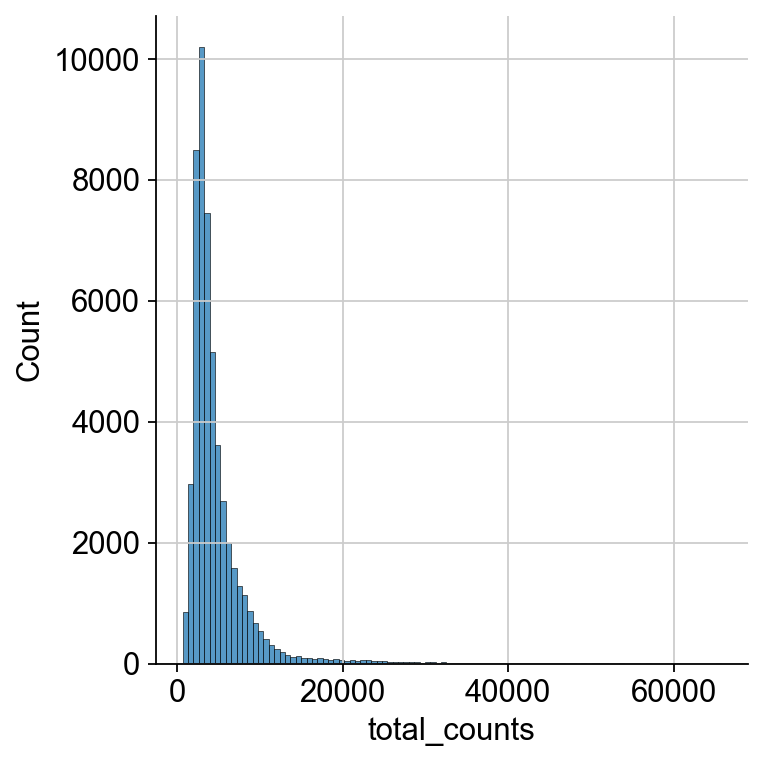

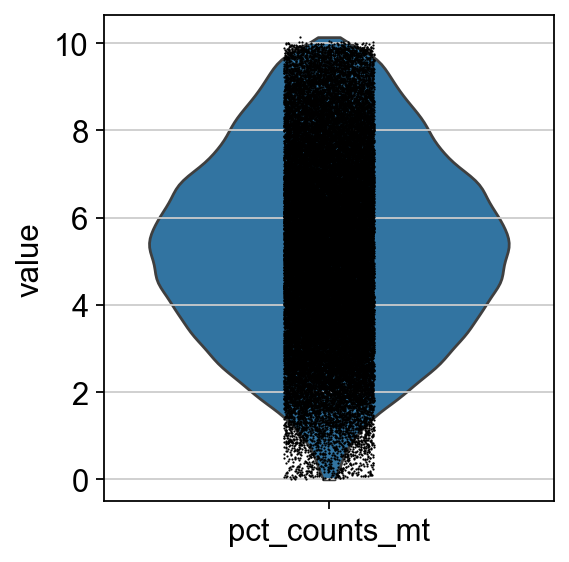

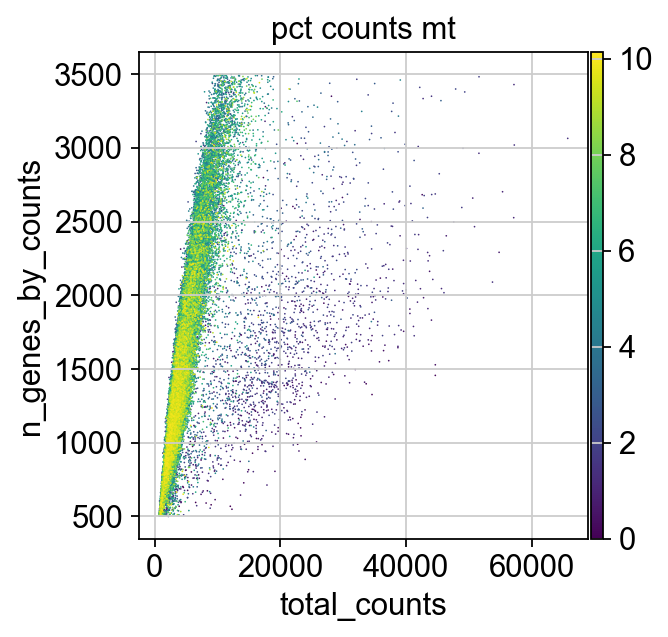

In [ ]:
# display QC metrics as per best practices tutorial

p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## SCRAN normalisation

Follows best practices tutorial to create an adata layer where scran counts are stored

In [15]:
from scipy.sparse import csr_matrix, issparse

In [16]:
%%R
library(scran)
library(BiocParallel)

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOr

In [17]:
# Preliminary clustering for differentiated normalisation
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

/Users/alex/miniconda3/envs/scanpy_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/gv/57z5thfs7kqfq2njhk1gg9jc0000gn/T/ipykernel_1315/2214793430.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_pp, key_added="groups")


In [ ]:
data_mat = adata_pp.X.T

if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()
ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata_pp.obs["groups"]

In [19]:
del adata_pp

In [20]:
%%R -o size_factors

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam()
    )
)

In [21]:
adata.obs["size_factors"] = size_factors
scran = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran))


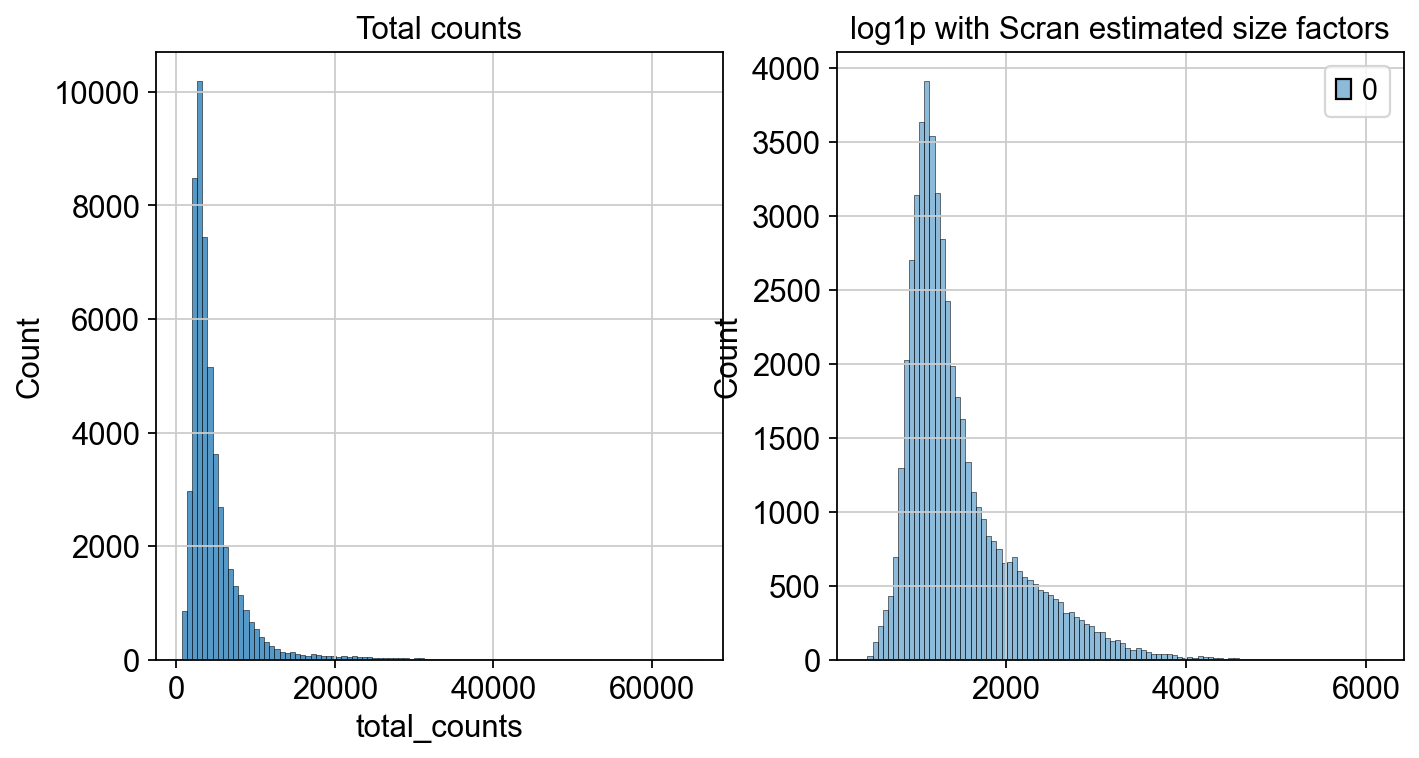

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["scran_normalization"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("log1p with Scran estimated size factors")
plt.show()

# Shifted log normalisation

In [ ]:
#Set default layer to raw counts (rounded as per discussion with Cenk)

adata.X = adata.layers['rounded_raw_counts']

In [ ]:
#shift normalise counts as per best practices tutorial

scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

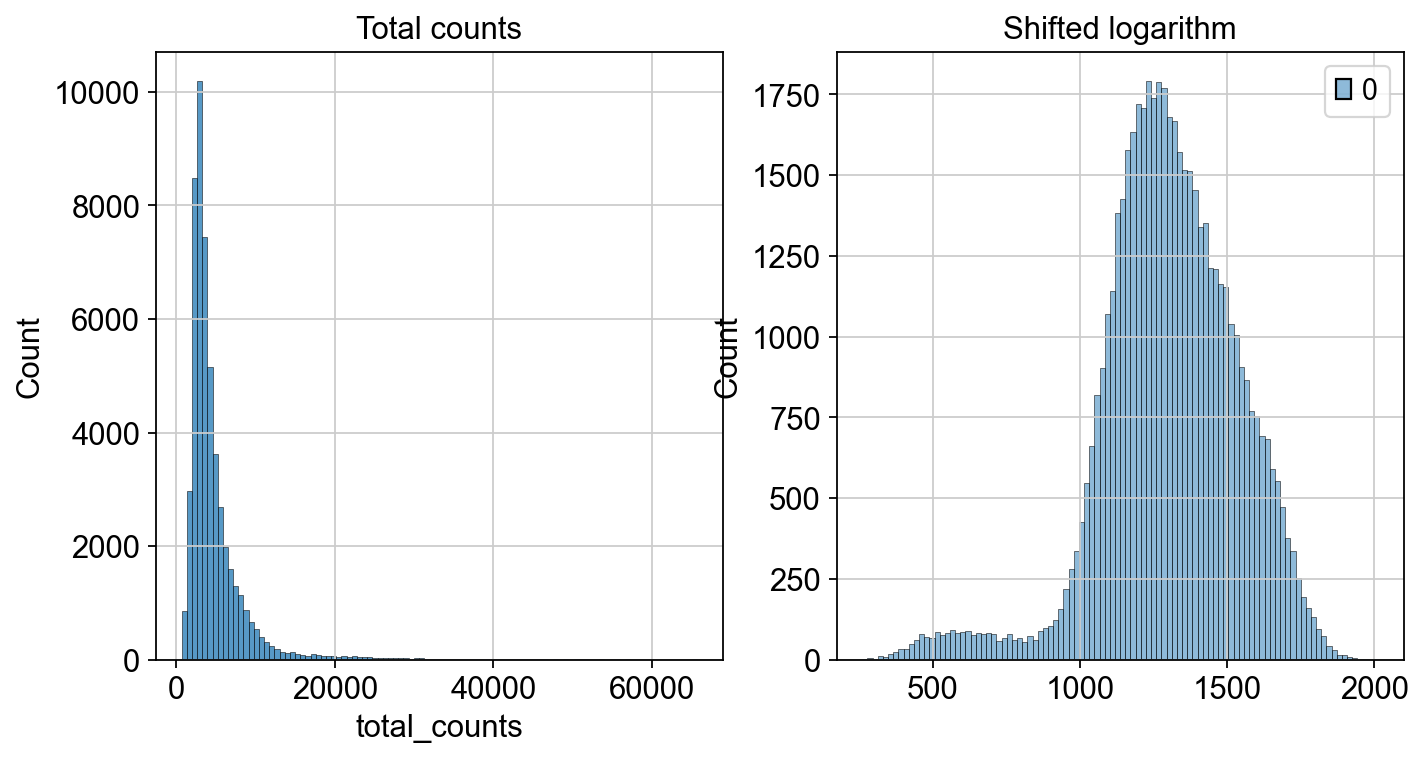

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs['total_counts'], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

# Exporting/subsetting data - COPYKAT and SCEVAN raw expression matrix

In [ ]:
#make cell ids a column of .obs for easier handling in some cases later

adata.obs['cell_ids'] = adata.obs.index

In [39]:
adata.obs['cell_ids']

AAACCCAAGGAGACCT-1_1      AAACCCAAGGAGACCT-1_1
AAACCCAGTAGACAGC-1_1      AAACCCAGTAGACAGC-1_1
AAACCCAGTAGATCGG-1_1      AAACCCAGTAGATCGG-1_1
AAACCCAGTATCACCA-1_1      AAACCCAGTATCACCA-1_1
AAACCCAGTTGGAGGT-1_1      AAACCCAGTTGGAGGT-1_1
                                 ...          
TTTGGTTCATTGAAGA-1_10    TTTGGTTCATTGAAGA-1_10
TTTGGTTGTTGTCCCT-1_10    TTTGGTTGTTGTCCCT-1_10
TTTGGTTGTTTGACAC-1_10    TTTGGTTGTTTGACAC-1_10
TTTGTTGAGGGTCAAC-1_10    TTTGTTGAGGGTCAAC-1_10
TTTGTTGCATGGAGAC-1_10    TTTGTTGCATGGAGAC-1_10
Name: cell_ids, Length: 52387, dtype: object

## Raw epithelial counts for use w/ SCEVAN

In [ ]:
#make sure adata.X is the raw counts    
adata.X = adata.layers['rounded_raw_counts']

In [ ]:
#subset adata object to just epithelial and undetermined cells
#exclude normal tissue -> cannot be tumor cells

epithelial_und_adata = adata[adata.obs['tissueType'] != 'N']
epithelial_und_adata = epithelial_und_adata[epithelial_und_adata.obs['highLevelType'].isin(['Epithelial', 'Undetermined'])]

In [ ]:
#check have raw counts and expected number of cells
print(epithelial_und_adata.X.max())
print(epithelial_und_adata.X.shape)

23007.0
(2141, 25815)


In [ ]:
#check no normal tissue
epithelial_und_adata.obs['tissueType'].value_counts()

T    2141
Name: tissueType, dtype: int64

In [ ]:
#Make raw counts data frame and export to file
raw_counts = pd.DataFrame(epithelial_und_adata.X.toarray().T, index=epithelial_und_adata.var.index, columns=epithelial_und_adata.obs.cell_ids)
raw_counts.to_csv("epi_und_raw_counts.csv", sep=",", index=True, header=True)

## Subsampling for healthy reference - DEPRECATED, not used in diss

In [12]:
temp_adata = adata[adata.obs['tissueType'] == 'N']

In [13]:
temp_adata.obs.ident.value_counts()

B               2141
Endothelial     1702
T               1580
Fibroblast       965
Myeloid          365
Plasmablast      355
Undetermined     299
NK               230
Mast             170
Epithelial        71
Cycling           10
Name: ident, dtype: int64

In [14]:
temp_adata = temp_adata[temp_adata.obs['ident'] != 'Cycling']

In [15]:
temp_adata = temp_adata[temp_adata.obs["highLevelType"] != "Undetermined"]

In [16]:
adata_df = pd.DataFrame(temp_adata.obs).reset_index()

In [17]:
normal_ref = adata_df.groupby('highLevelType').sample(71)['index']

In [18]:
len(list(normal_ref))

639

In [56]:
normal_ref.to_csv("normal_cell_ids.csv", sep=",")

In [20]:
epi_und_cell_ids = list(epithelial_und_adata.obs.index)
len(epi_und_cell_ids)

2141

In [21]:
normal_epi_und_ids =  list(normal_ref) + epi_und_cell_ids

In [22]:
len(normal_epi_und_ids)


2780

## Raw counts w/ healthy cells

In [23]:
mask = adata.obs.index.isin(normal_epi_und_ids)

In [24]:
raw_counts_to_export = adata[mask].copy()

In [25]:
raw_counts_to_export.X.shape

(2780, 25815)

In [26]:
raw_counts_to_export.X.max()

26139.0

In [27]:
raw_counts_to_export

AnnData object with n_obs × n_vars = 2780 × 25815
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample_ID', 'donor', 'chemo', 'tissueType', 'dataType', 'Mandard', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'doublet', 'pANN', 'integrated_snn_res.0.7', 'seurat_clusters', 'SingleR_hpca_coarse', 'SingleR_hpca_fine', 'SingleR_monaco', 'SingleR_immCellExp', 'highLevelType', 'ident', 'cell_ids', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'size_factors', 'tumor', 'G0_class', 'cell_type'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'X_name'
    layers: 'log

In [39]:
raw_counts_to_export.X = raw_counts_to_export.layers['scran_normalization']

In [28]:
raw_counts_to_export = pd.DataFrame(raw_counts_to_export.X.toarray().T, index=raw_counts_to_export.var.index, columns=raw_counts_to_export.obs.index)
raw_counts_to_export.to_csv("epi_und_TME_raw_counts.csv", sep=",", index=True, header=True)

In [29]:
raw_counts_to_export.shape

(25815, 2780)

# Importing and assessing copyKAT annotation

In [81]:
copyKAT_TME = pd.read_csv('/Users/alex/Documents/BIOL0041-Project/OAC_masters_project/data/copyKAT_tumors_TME.csv')

In [83]:
copyKAT_TME = copyKAT_TME.drop(0)
copyKAT_TME = copyKAT_TME[['x']]

In [ ]:
# create function to make copykat mapping dictionary 

def copyKAT_mapDict(copyKAT_results):
    tum_dict = {}

    for cellID in list(copyKAT_results.loc[:,'x']):
        tum_dict[cellID.replace('.','-')] = 'tumor'
    return(tum_dict)

#create mapping dictionary
cKAT_tum_dict_TME = copyKAT_mapDict(copyKAT_TME)

In [ ]:
#map copykat annotations to adata.obs
adata.obs["tumor"] = adata.obs.index.map(cKAT_tum_dict_TME)

In [93]:
adata.obs["tumor"].value_counts()

tumor    1447
Name: tumor, dtype: int64

In [ ]:
# subsetting to just tumor adata object
tumor_adata = adata[adata.obs.tumor == 'tumor']

In [96]:
tumor_adata.obs.tissueType.value_counts()

T    1043
N     404
Name: tissueType, dtype: int64

CopyKAT also classifies some of the adjacent normal tissue as malignant -> will stick with just agreement on epi and undetermined cells

In [105]:
copyKAT_TME = copyKAT_TME.drop(0)
copyKAT_TME = copyKAT_TME[['x']]

KeyError: '[0] not found in axis'

# Integrating and assessing SCEVAN annotation

In [ ]:
#comment out as appropriate

SCEVAN_results_noTME = pd.read_csv('/Users/alex/Documents/BIOL0041-Project/OAC_masters_project/data/SCEVAN_results_epi_und_noRef.csv', header=None)

SCEVAN_results_TME = pd.read_csv('/Users/alex/Documents/BIOL0041-Project/OAC_masters_project/data/SCEVAN_results_epi_und_TME.csv', header = None)

In [30]:
SCEVAN_results_noTME = SCEVAN_results_noTME.drop(0)
SCEVAN_results_TME = SCEVAN_results_TME.drop(0)

In [31]:
SCEVAN_results_noTME = SCEVAN_results_noTME[[0,1,3]]
SCEVAN_results_TME = SCEVAN_results_TME[[0,1,3]]

In [32]:
SCEVAN_results_noTME[1].value_counts()

tumor       1174
normal       663
filtered     304
Name: 1, dtype: int64

In [33]:
SCEVAN_results_TME[1].value_counts()

tumor       1611
normal       832
filtered     337
Name: 1, dtype: int64

In [ ]:
def SCEVAN_map_dict(SCEVAN_results):
    # create mapping dictionary - cell ID matched to tumoural status and subclone (if tumoural)
    tum_dict = {}
    clone_dict = {}

    for i in range(1, len(SCEVAN_results)+1):
        cellID = SCEVAN_results.loc[i][0].replace('.','-')
        tum_type = SCEVAN_results.loc[i][1]

        #non tumoural sublcones set to 0
        if str(SCEVAN_results.loc[i][3]) == 'nan':
            subclone = 0
        else:
            subclone = SCEVAN_results.loc[i][3]

        if tum_type != 'normal' and tum_type != 'filtered':
            tum_dict[cellID] = tum_type
        clone_dict[cellID] = subclone

    return(tum_dict, clone_dict)

In [40]:
tum_dict_TME = SCEVAN_map_dict(SCEVAN_results_TME)[0]  
subclone_dict_TME = SCEVAN_map_dict(SCEVAN_results_TME)[1]  

In [41]:
tum_dict_noTME = SCEVAN_map_dict(SCEVAN_results_noTME)[0]  
subclone_dict_noTME = SCEVAN_map_dict(SCEVAN_results_noTME)[1]  

## Checking for classification of cells from normal adjacent tissue as tumoral

In [43]:
adata.obs["tumor"] = adata.obs.index.map(tum_dict_TME)
adata.obs["subclone"] = adata.obs.index.map(subclone_dict_TME)

In [ ]:
adata.obs.tumor.value_counts()

Series([], Name: tumor, dtype: int64)

In [45]:
tumor_adata = adata[adata.obs.tumor == 'tumor']

In [48]:
tumor_adata.obs.tissueType.value_counts()

T    1201
N     410
Name: tissueType, dtype: int64

Normal adjacent tissue cells are classified as tumor by SCEVAN

# Intergrating SCEVAN/copyKAT output agreement

In [7]:
SCEVAN_results_noTME = pd.read_csv('/Users/alex/Documents/BIOL0041-Project/OAC_masters_project/data/SCEVAN_results_epi_und_noRef.csv', header=None)
copyKAT_noTME = pd.read_csv('/Users/alex/Documents/BIOL0041-Project/OAC_masters_project/data/copyKAT_tumors_noTME.csv')

In [8]:
SCEVAN_results_noTME

,0,1,2,3
0,NaN,class,confidentNormal,subclone
1,AAACGCTTCATCTACT.1_1,normal,NaN,NaN
2,AAAGTGATCAACGCTA.1_1,normal,NaN,NaN
3,AACCATGTCGAATGCT.1_1,tumor,NaN,1
4,AACGGGATCTTCCTAA.1_1,normal,NaN,NaN
...,...,...,...,...
2137,TTGGGTATCAAGAAAC.1_10,normal,NaN,NaN
2138,TTTACGTAGAGTCAAT.1_10,normal,NaN,NaN
2139,TTTCATGAGATACATG.1_10,normal,NaN,NaN
2140,TTTGACTGTTCCACAA.1_10,normal,NaN,NaN


In [9]:
copyKAT_noTME

,Unnamed: 0,x
0,1,AAACGCTTCATCTACT.1_1
1,2,AAAGTGATCAACGCTA.1_1
2,3,AACCATGTCGAATGCT.1_1
3,4,AATGAAGAGGCTTTCA.1_1
4,5,AGGCATTCACTTGGGC.1_1
...,...,...
939,940,AGAACAATCTTCGATT.1_10
940,941,AGCCAATAGACATAGT.1_10
941,942,ATTACCTTCGATCCCT.1_10
942,943,CCCTTAGAGCTTCATG.1_10


In [10]:
SCEVAN_results_noTME = SCEVAN_results_noTME.drop(0)
SCEVAN_results_noTME = SCEVAN_results_noTME[[0,1,3]]
SCEVAN_results_noTME = SCEVAN_results_noTME[SCEVAN_results_noTME[1] == 'tumor']
SCEVAN_results_noTME.iloc[:,1].value_counts()

tumor    1174
Name: 1, dtype: int64

In [11]:
SCEVAN_results_noTME = list(SCEVAN_results_noTME.iloc[:,0])

In [13]:
len(SCEVAN_results_noTME)

1174

In [ ]:
copyKAT_noTME = copyKAT_noTME.drop(0)
copyKAT_noTME = list(copyKAT_noTME.loc[:,'x'])

In [ ]:
#fix change of cellular ID format
copyKAT_noTME = [item.replace('.', '-') for item in copyKAT_noTME]

In [17]:
len(copyKAT_noTME)

943

In [209]:
agreement_IDs = copyKAT_noTME in SCEVAN_results_noTME

In [221]:
agreement_IDs = list(set(copyKAT_noTME) & set(SCEVAN_results_noTME))

In [223]:
len(agreement_IDs)

912

In [226]:
agreement_tum_dict = {}

for cellID in list(agreement_IDs):
    agreement_tum_dict[cellID.replace('.','-')] = 'tumor'

In [227]:
agreement_tum_dict

{'ATTTACCCATGGGTTT-1_2': 'tumor',
 'AACAAGAGTATGGTAA-1_8': 'tumor',
 'GTAGGAGGTCTTGAGT-1_8': 'tumor',
 'TCACGGGAGGTAGGCT-1_2': 'tumor',
 'CGAGGCTAGCCACTCG-1_5': 'tumor',
 'GACTATGCACAAACGG-1_2': 'tumor',
 'CCTCAGTCACGCGCTA-1_2': 'tumor',
 'ATGATCGCATAGTCAC-1_6': 'tumor',
 'TAGCACATCTCGTGGG-1_2': 'tumor',
 'AAATGGATCATTGGTG-1_6': 'tumor',
 'AAGCCATGTAAGATTG-1_2': 'tumor',
 'TGCGGGTGTAATGATG-1_8': 'tumor',
 'ACCCAAACATGGGTTT-1_2': 'tumor',
 'CCTCAGTCACACCTTC-1_5': 'tumor',
 'GCCAGGTGTCTCGACG-1_8': 'tumor',
 'TTCCGGTAGTGCCCGT-1_6': 'tumor',
 'ATAGGCTAGGACGCTA-1_4': 'tumor',
 'ACGGAAGCAGACAAGC-1_2': 'tumor',
 'GTCCACTGTTGTCATG-1_2': 'tumor',
 'GCAACATCAGTAACAA-1_4': 'tumor',
 'GGGACTCTCCCATGGG-1_2': 'tumor',
 'GTCCCATCACATCATG-1_6': 'tumor',
 'ATTCTACGTTCAGTAC-1_2': 'tumor',
 'CATAGACCAAGATGGC-1_4': 'tumor',
 'GACTCAAGTGTTCGAT-1_5': 'tumor',
 'GAACTGTCATACCAGT-1_2': 'tumor',
 'CTCTCGATCCACAGGC-1_5': 'tumor',
 'ATTGTTCAGAACGTGC-1_6': 'tumor',
 'CGCCATTTCTTTGATC-1_2': 'tumor',
 'CAACCAACAGTA

# Export tumor SCRAN counts for downstream analysis

In [236]:
adata.X = adata.layers['scran_normalization']

In [237]:
adata.obs["tumor"] = adata.obs.index.map(agreement_tum_dict)

In [238]:
tumor_adata = adata[adata.obs.tumor == 'tumor']

In [239]:
tumor_adata.obs.tissueType.value_counts()

T    912
Name: tissueType, dtype: int64

In [ ]:
#double check it is SCRAN counts
tumor_adata.X.max()

10.860676692854359

In [241]:
SCRAN_counts_tumor = pd.DataFrame(tumor_adata.X.toarray().T, index=tumor_adata.var.index, columns=tumor_adata.obs.index)
SCRAN_counts_tumor.to_csv("agreement_tum_SCRAN_counts.csv", sep=",", index=True, header=True)

# Importing QuieScore/G0 scoring

In [29]:
G0_results = pd.read_csv('/Users/alex/Documents/BIOL0041-Project/OAC_masters_project/data/G0_agreement_quartiles.csv', header=None)

In [31]:
G0_results.columns = ['cell_id', 'G0_up', 'G0_down', 'Prolif_cap', 'Prolif_z', 'split_class', 'final_class']

In [32]:
G0_results = G0_results.drop(0)

In [35]:
G0_results.final_class.value_counts()

cycling         456
G0 arrested     228
fast cycling    228
Name: final_class, dtype: int64

In [36]:
# create mapping dictionary - cell ID matched to final G0 classification
G0_dict = {}

for i in range(1, len(G0_results)+1):
    cellID = G0_results.loc[i]['cell_id'].replace('.','-')
    G0_class = G0_results.loc[i]['final_class']

    G0_dict[cellID] = G0_class

print(G0_dict)

{'AACCATGTCGAATGCT-1_1': 'cycling', 'AATGAAGAGGCTTTCA-1_1': 'G0 arrested', 'AGGCATTCACTTGGGC-1_1': 'fast cycling', 'ATTTCACGTCCTACGG-1_1': 'fast cycling', 'CCACACTGTGGCTTAT-1_1': 'fast cycling', 'GTCACGGAGCTAAATG-1_1': 'fast cycling', 'GTTGAACTCGACCAAT-1_1': 'cycling', 'TCGACGGTCCGTGTAA-1_1': 'cycling', 'AAACCCAGTCGTGGTC-1_2': 'G0 arrested', 'AAAGAACCACTAACCA-1_2': 'cycling', 'AAAGGATTCACTTATC-1_2': 'cycling', 'AAAGTCCTCGGATACT-1_2': 'G0 arrested', 'AAAGTGACAGGCCCTA-1_2': 'cycling', 'AAATGGAGTTGCCGCA-1_2': 'cycling', 'AACAACCGTCAGTCGC-1_2': 'fast cycling', 'AACCAACTCATCCTGC-1_2': 'cycling', 'AACCCAATCGCCAATA-1_2': 'cycling', 'AACCTGACACCTAAAC-1_2': 'fast cycling', 'AACGGGAAGTAGAGTT-1_2': 'G0 arrested', 'AACGTCAAGTAAGAGG-1_2': 'cycling', 'AAGACAATCAGCAGAG-1_2': 'cycling', 'AAGATAGTCCAGCACG-1_2': 'fast cycling', 'AAGCATCCACCTGATA-1_2': 'cycling', 'AAGCCATCATGCCGAC-1_2': 'fast cycling', 'AAGCCATGTAAGATTG-1_2': 'G0 arrested', 'AAGCCATGTCCACAGC-1_2': 'G0 arrested', 'AAGGAATAGAATCGCG-1_2': '

In [37]:
adata.obs["G0_class"] = adata.obs.index.map(G0_dict)

In [19]:
adata.obs.G0_class.value_counts()

cycling         456
G0 arrested     228
fast cycling    228
Name: G0_class, dtype: int64

# Wilcoxon-test for DGE expression

In [3]:
tumor_adata = adata[adata.obs["tumor"] == "tumor"]

In [4]:
fast_G0_adata = adata[adata.obs['cell_type'].isin(['Fast cycling-Tum', 'G0 arrested-Tum'])]

In [22]:
fast_G0_adata.obs['cell_type'] = fast_G0_adata.obs['cell_type'].replace('G0 arrested-Tum', 'G0 arrested Tumor')
fast_G0_adata.obs['cell_type'] = fast_G0_adata.obs['cell_type'].replace('Fast cycling-Tum', 'Fast cycling Tumor')

In [5]:
#swap to shifted log counts as this is what rank_genes_groups expects
fast_G0_adata.X = fast_G0_adata.layers['log1p_norm']

/Users/alex/miniconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:617: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)


In [6]:
fast_G0_adata.layers['rounded_raw_counts'].max()

23007.0

In [23]:
fast_G0_adata.obs.cell_type.value_counts()

Fast cycling Tumor    228
G0 arrested Tumor     228
Name: cell_type, dtype: int64

In [24]:
sc.tl.rank_genes_groups(fast_G0_adata, "cell_type", method="wilcoxon", layer='log1p_norm')

In [ ]:
fast_G0_DE = sc.get.rank_genes_groups_df(fast_G0_adata, group= "Fast cycling Tumor")

In [29]:
G0_DE = sc.get.rank_genes_groups_df(fast_G0_adata, group= "G0 arrested Tumor")

In [30]:
G0_DE = G0_DE[G0_DE['pvals_adj'] < 0.05]

In [31]:
G0_DE

,names,scores,logfoldchanges,pvals,pvals_adj
0,CD63,7.062055,1.717748,1.640577e-12,1.058787e-08
1,CST3,6.795180,2.117021,1.081770e-11,3.102878e-08
2,CTSD,6.212747,1.698550,5.206639e-10,8.400586e-07
3,CLU,6.186805,2.334497,6.139570e-10,9.323118e-07
4,FTL,6.110403,0.744755,9.937981e-10,1.221662e-06
...,...,...,...,...,...
25810,RPS14,-6.858079,-0.522394,6.979264e-12,2.738849e-08
25811,RPS27,-7.014082,-0.590264,2.314640e-12,1.195049e-08
25812,RPS16,-7.104698,-0.824087,1.205856e-12,1.037639e-08
25813,RPS21,-7.404266,-0.699066,1.318776e-13,1.702210e-09


In [27]:
sig_fast_G0_DE = fast_G0_DE[fast_G0_DE['pvals_adj'] < 0.05]

In [28]:
sig_fast_G0_DE

,names,scores,logfoldchanges,pvals,pvals_adj
0,RPLP1,7.495594,0.590132,6.599898e-14,1.702210e-09
1,RPS21,7.404266,0.699066,1.318776e-13,1.702210e-09
2,RPS16,7.104698,0.824087,1.205856e-12,1.037639e-08
3,RPS27,7.014082,0.590264,2.314640e-12,1.195049e-08
4,RPS14,6.858079,0.522394,6.979264e-12,2.738849e-08
...,...,...,...,...,...
25810,FTL,-6.110403,-0.744755,9.937981e-10,1.221662e-06
25811,CLU,-6.186805,-2.334497,6.139570e-10,9.323118e-07
25812,CTSD,-6.212747,-1.698550,5.206639e-10,8.400586e-07
25813,CST3,-6.795180,-2.117021,1.081770e-11,3.102878e-08


In [44]:
cpdb_DEG_df = pd.DataFrame({
    'cluster': ['Fast cycling Tumor'] * len(sig_fast_G0_DE),
    'gene': sig_fast_G0_DE['names'].values
})

In [46]:
cpdb_DEG_df2 = pd.DataFrame({
    'cluster': ['G0 arrested Tumor'] * len(sig_fast_G0_DE),
    'gene': sig_fast_G0_DE['names'].values
})

In [47]:
cpdb_DEG_df2

,cluster,gene
0,G0 arrested Tumor,RPLP1
1,G0 arrested Tumor,RPLP1
2,G0 arrested Tumor,RPS16
3,G0 arrested Tumor,RPS27
4,G0 arrested Tumor,RPS14
...,...,...
181,G0 arrested Tumor,FTL
182,G0 arrested Tumor,CLU
183,G0 arrested Tumor,CTSD
184,G0 arrested Tumor,CST3


In [48]:
final_cpdb_DEG_df = pd.concat([cpdb_DEG_df, cpdb_DEG_df2], ignore_index=True)

In [50]:
final_cpdb_DEG_df.to_csv('fast_G0_tumCells_DEGs.tsv', index=False, sep='\t')

In [ ]:
#export results as csv file
fast_G0_DE.to_csv("fast_G0_DE.csv", sep=",", index=False, header=True)

In [13]:
#export results as csv file
fast_G0_DE.to_csv("fast_G0_DE.csv", sep=",", index=False, header=True)

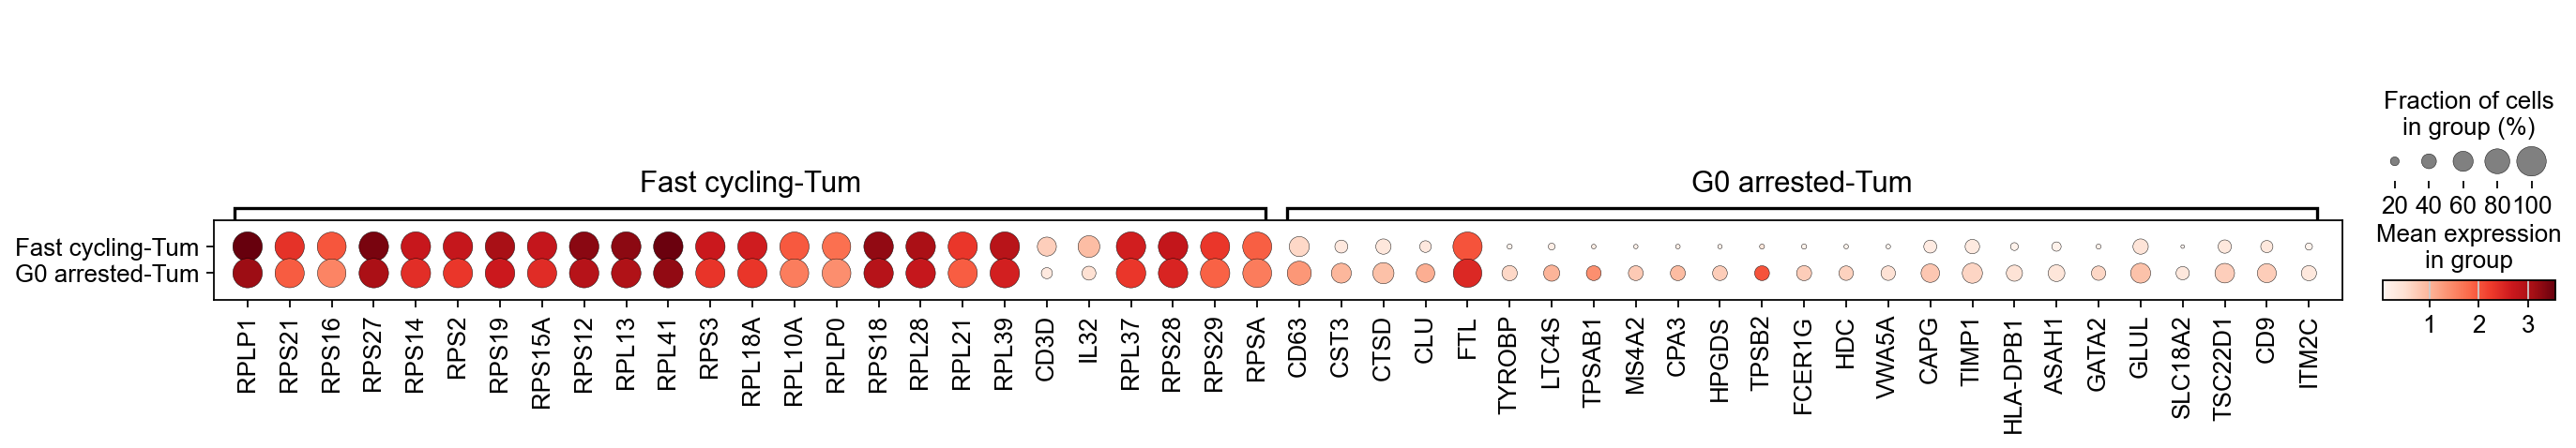

In [14]:
sc.pl.rank_genes_groups_dotplot(fast_G0_adata, var_group_rotation = 0, n_genes= 25)

In [16]:
sc.tl.rank_genes_groups(tumor_adata, "chemo", method="wilcoxon", layer='log1p_norm')

/Users/alex/miniconda3/envs/scanpy_env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:639: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


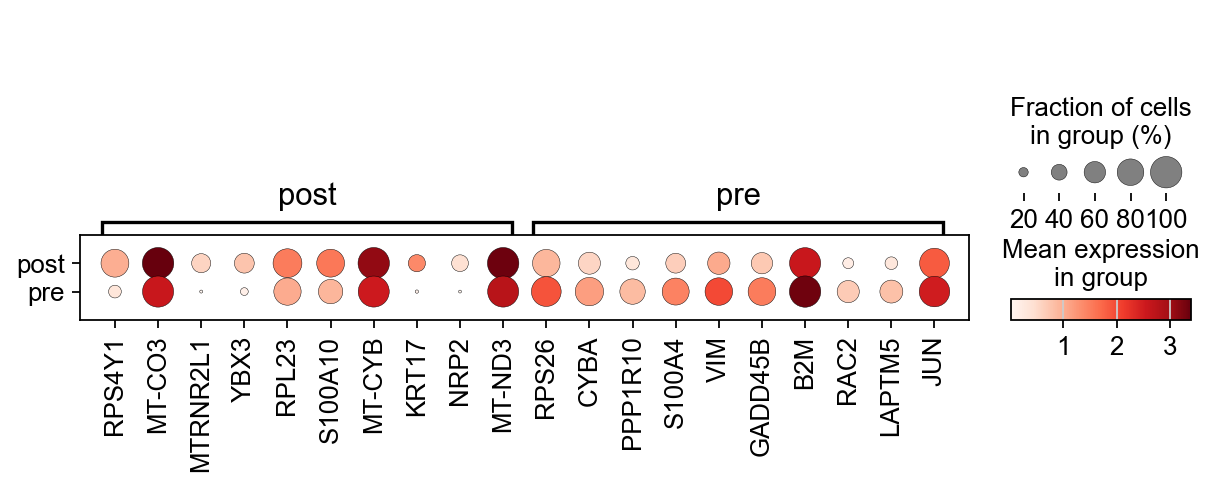

In [21]:
sc.pl.rank_genes_groups_dotplot(tumor_adata, var_group_rotation = 0)

# pyDESEQ2 - DEPRECATED, no DEGs identified likely due to low sensitivity in sparse, low depth-dataset + small number of tumor cells per sample in some cases

In [384]:
tumor_adata = adata[adata.obs["tumor"] == "tumor"]

In [385]:
tumor_adata = tumor_adata[tumor_adata.obs["tissueType"] != "N"]

In [389]:
tumor_adata.X = tumor_adata.layers['rounded_raw_counts']

In [ ]:
# make pseudo-bulk samples to test for DEGs between G0 and fast cycling cells - code adapted from Sanbiomics tutorial

pbs =[]

for sample in tumor_adata.obs.sample_ID.unique():
    cell_sample_subset = tumor_adata[tumor_adata.obs['sample_ID'] == sample]
    
    G0_subset = cell_sample_subset[cell_sample_subset.obs['G0_class'] == 'G0 arrested']
    fast_subset = cell_sample_subset[cell_sample_subset.obs['G0_class'] == 'fast cycling']


    if G0_subset.X.shape[0] > 0:
        print(G0_subset.X.shape)
        rep_adata1 = sc.AnnData(X = G0_subset.X.sum(axis=0),
                            var = G0_subset.var[[]])
        
        rep_adata1.obs_names = [sample]
        rep_adata1.obs['G0_class'] = 'G0_arrested'

        pbs.append(rep_adata1)

    if fast_subset.X.shape[0] > 0:
        print(fast_subset.X.shape)
        rep_adata2 = sc.AnnData(X = fast_subset.X.sum(axis=0),
                            var = fast_subset.var[[]])
        
        rep_adata2.obs_names = [sample]
        rep_adata2.obs['G0_class'] = 'fast'
        
        pbs.append(rep_adata2)

    
   

(1, 25815)
(4, 25815)
(117, 25815)
(87, 25815)
(3, 25815)
(7, 25815)
(26, 25815)
(47, 25815)
(28, 25815)
(35, 25815)
(9, 25815)
(13, 25815)
(41, 25815)
(33, 25815)
(3, 25815)
(2, 25815)


/Users/alex/miniconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
/Users/alex/miniconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
/Users/alex/miniconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
/Users/alex/miniconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
/Users/alex/miniconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/st

In [395]:
# make pseudo-bulk samples to test for DEGs between pre and post chemo cells

pbs =[]

for sample in tumor_adata.obs.sample_ID.unique():
    cell_sample_subset = tumor_adata[tumor_adata.obs['sample_ID'] == sample]
    
    pre_subset = cell_sample_subset[cell_sample_subset.obs['chemo'] == 'pre']
    post_subset = cell_sample_subset[cell_sample_subset.obs['chemo'] == 'post']

    if pre_subset.X.shape[0] > 0:
        print(pre_subset.X.shape)
        rep_adata1 = sc.AnnData(X = pre_subset.X.sum(axis=0),
                           var = pre_subset.var[[]])
    
        rep_adata1.obs_names = [sample]
        rep_adata1.obs['chemo'] = 'pre'
        pbs.append(rep_adata1)

    if post_subset.X.shape[0] > 0:
        print(post_subset.X.shape)
        rep_adata2 = sc.AnnData(X = post_subset.X.sum(axis=0),
                            var = post_subset.var[[]])
        
        rep_adata2.obs_names = [sample]
        rep_adata2.obs['chemo'] = 'post'
        pbs.append(rep_adata2)

(8, 25815)
(422, 25815)
(20, 25815)
(139, 25815)
(150, 25815)
(41, 25815)
(127, 25815)
(5, 25815)


/Users/alex/miniconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
/Users/alex/miniconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
/Users/alex/miniconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
/Users/alex/miniconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
/Users/alex/miniconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/st

In [ ]:
#check get expression measurements in each pseudo-bulk sample, i.e. concatenation has happened as expected
for x in pbs:
    print(x.X.max())

231.0
745.0
20859.0
11710.0
397.0
1086.0
22673.0
28116.0
8666.0
9965.0
2737.0
4030.0
83161.0
14197.0
8018.0
775.0


In [398]:
pb = sc.concat(pbs)

/Users/alex/miniconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [399]:
pb.obs

,G0_class
s1,G0_arrested
s1,fast
s2,G0_arrested
s2,fast
s3,G0_arrested
s3,fast
s4,G0_arrested
s4,fast
s5,G0_arrested
s5,fast


In [400]:
pb.obs['sample'] = pb.obs.index

In [401]:
pb.obs_names_make_unique()

In [402]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [403]:
counts = pd.DataFrame(pb.X, columns = pb.var_names)

In [404]:
counts

,AL627309.1,AL669831.5,LINC00115,FAM41C,AL645608.1,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,...,AC004471.1,IGLV11-55,RNF185-AS1,IGLCOR22-2,APOL5,AP000322.2,LINC00322,LINC00319,LINC00315,LINC00316
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,2.0,0.0,0.0,0.0,21.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,2.0,1.0,0.0,0.0,1.0,14.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,2.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,1.0,0.0,1.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [406]:
dds = DeseqDataSet(
    counts = counts,
    metadata=pb.obs,
    design_factors= ['G0_class']
)

/var/folders/gv/57z5thfs7kqfq2njhk1gg9jc0000gn/T/ipykernel_8623/129980444.py:1: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(


In [408]:
dds

AnnData object with n_obs × n_vars = 16 × 25815
    obs: 'G0_class', 'sample'
    uns: 'mean_disp', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions'
    layers: 'normed_counts', '_mu_hat'

In [409]:
sc.pp.filter_genes(dds, min_cells=1)

In [410]:
dds

AnnData object with n_obs × n_vars = 16 × 18092
    obs: 'G0_class', 'sample'
    var: 'n_cells'
    uns: 'mean_disp', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions'
    layers: 'normed_counts', '_mu_hat'

In [411]:
dds.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.23 seconds.

Fitting dispersion trend curve...
/Users/alex/miniconda3/envs/scanpy_env/lib/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.23 seconds.

Fitting MAP dispersions...
... done in 2.97 seconds.

Fitting LFCs...
... done in 2.37 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 431 outlier genes.

Fitting dispersions...
... done in 0.07 seconds.

Fitting MAP dispersions...
... done in 0.10 seconds.

Fitting LFCs...
... done in 0.07 seconds.



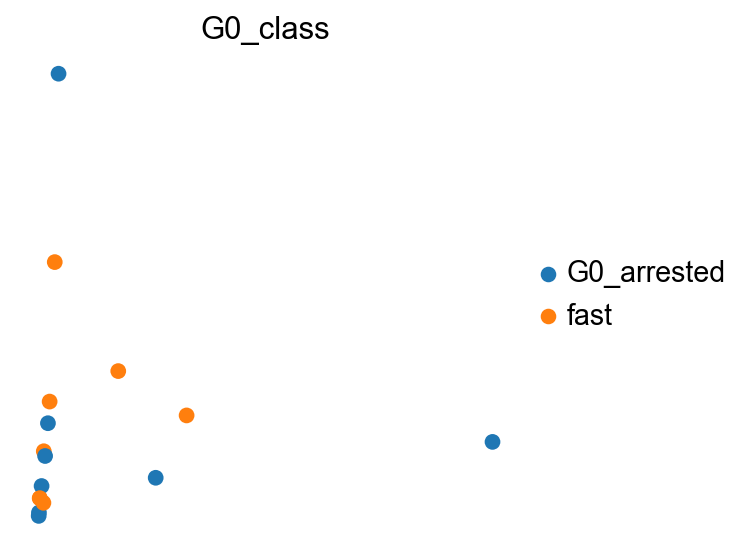

In [413]:
sc.tl.pca(dds)
sc.pl.pca(dds, color = "G0_class", size = 200)

In [414]:
stat_res = DeseqStats(dds, contrast=('G0_class', 'G0_arrested', 'fast'))

stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: G0_class G0_arrested vs fast
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AL627309.1  0.034426        1.446378  2.941919  0.491644  0.622971  0.992685
AL669831.5  0.289255        0.349590  1.205973  0.289882  0.771906  0.992685
LINC00115   0.513490       -0.980928  1.905930 -0.514672  0.606783  0.992685
FAM41C      0.270243        1.285362  1.935027  0.664261  0.506523  0.992685
SAMD11      0.103889        0.902917  1.772996  0.509260  0.610570  0.992685
...              ...             ...       ...       ...       ...       ...
AC008406.3  0.196764        2.039350  3.338111  0.610929  0.541246  0.992685
LINC01269   0.590292        3.625227  3.237657  1.119707  0.262839  0.992685
AC142086.1  0.196764        2.039350  3.338111  0.610929  0.541246  0.992685
KRTAP3-2    0.000000        0.000000  0.000000  0.000000       NaN       NaN
LINC00319   0.196764        2.039350  3.338111  0.610929  0.541246  0.992685

[18092 r

... done in 1.17 seconds.



In [415]:
stat_res = DeseqStats(dds, contrast=('chemo', 'pre', 'post'))

stat_res.summary()

ValueError: You specified a variable that is not part of the model. Available variables: G0_class

In [416]:
de = stat_res.results_df

In [417]:
de

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AL627309.1,0.034426,1.446378,2.941919,0.491644,0.622971,0.992685
AL669831.5,0.289255,0.349590,1.205973,0.289882,0.771906,0.992685
LINC00115,0.513490,-0.980928,1.905930,-0.514672,0.606783,0.992685
FAM41C,0.270243,1.285362,1.935027,0.664261,0.506523,0.992685
SAMD11,0.103889,0.902917,1.772996,0.509260,0.610570,0.992685
...,...,...,...,...,...,...
AC008406.3,0.196764,2.039350,3.338111,0.610929,0.541246,0.992685
LINC01269,0.590292,3.625227,3.237657,1.119707,0.262839,0.992685
AC142086.1,0.196764,2.039350,3.338111,0.610929,0.541246,0.992685
KRTAP3-2,0.000000,0.000000,0.000000,0.000000,NaN,NaN


In [559]:
de.to_csv("DGE_chemo.csv", sep=",", index=True, header=True)

In [418]:
test = de[de.padj < 0.05]

In [419]:
test

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj


# CellPhoneDB file generation

## Metadata

In [51]:
adata

AnnData object with n_obs × n_vars = 52387 × 25815
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample_ID', 'donor', 'chemo', 'tissueType', 'dataType', 'Mandard', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'doublet', 'pANN', 'integrated_snn_res.0.7', 'seurat_clusters', 'SingleR_hpca_coarse', 'SingleR_hpca_fine', 'SingleR_monaco', 'SingleR_immCellExp', 'highLevelType', 'ident', 'cell_ids', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'size_factors', 'tumor', 'G0_class', 'cell_type'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'log1p_norm', 'logcou

In [53]:
adata_obs_df = pd.DataFrame(adata.obs)

In [54]:
adata_obs_df['cell_type'] = adata.obs.ident

In [55]:
adata_obs_df['cell_type'].value_counts()

T               24998
B                6856
Fibroblast       4772
Myeloid          3055
NK               3013
Endothelial      2781
Plasmablast      2334
Mast             1631
Undetermined     1550
Epithelial        961
Cycling           436
Name: cell_type, dtype: int64

In [56]:
adata_obs_df['cell_type'] = np.where(~adata_obs_df['tumor'].isna(), adata_obs_df['tumor'],  adata_obs_df['cell_type'])

In [57]:
adata_obs_df['cell_type'] = np.where(~adata_obs_df['G0_class'].isna(), adata_obs_df['G0_class'],  adata_obs_df['cell_type'])

In [58]:
adata_obs_df['cell_type'] = adata_obs_df['cell_type'].replace('cycling', 'Cycling Tumor')
adata_obs_df['cell_type'] = adata_obs_df['cell_type'].replace('G0 arrested', 'G0 arrested Tumor')
adata_obs_df['cell_type'] = adata_obs_df['cell_type'].replace('fast cycling', 'Fast cycling Tumor')

In [59]:
adata_obs_df.cell_type.value_counts()

T                     24998
B                      6856
Fibroblast             4772
Myeloid                3055
NK                     3013
Endothelial            2781
Plasmablast            2334
Mast                   1631
Undetermined           1005
Epithelial              594
Cycling Tumor           456
Cycling                 436
G0 arrested Tumor       228
Fast cycling Tumor      228
Name: cell_type, dtype: int64

In [60]:
adata.obs = adata_obs_df

In [61]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,sample_ID,donor,chemo,tissueType,dataType,Mandard,percent.mt,...,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,size_factors,tumor,G0_class,cell_type
AAACCCAAGGAGACCT-1_1,SeuratProject,2137.550079,991,s1,Pt1,post,T,scRNA,3,6.051182,...,471.0,6.156979,21.846011,0.0,0.000000,0.000000,0.944667,NaN,NaN,T
AAACCCAGTAGACAGC-1_1,SeuratProject,2463.403303,1063,s1,Pt1,post,T,scRNA,3,3.331990,...,571.0,6.349139,22.977867,0.0,0.000000,0.000000,1.058626,NaN,NaN,T
AAACCCAGTAGATCGG-1_1,SeuratProject,1977.452999,855,s1,Pt1,post,T,scRNA,3,4.326229,...,701.0,6.553933,35.173106,1.0,0.693147,0.050176,0.883081,NaN,NaN,T
AAACCCAGTATCACCA-1_1,SeuratProject,2129.302222,1004,s1,Pt1,post,T,scRNA,3,6.450622,...,315.0,5.755742,14.671635,0.0,0.000000,0.000000,1.166406,NaN,NaN,B
AAACCCAGTTGGAGGT-1_1,SeuratProject,2419.105328,959,s1,Pt1,post,T,scRNA,3,4.385910,...,747.0,6.617403,30.639869,0.0,0.000000,0.000000,0.968688,NaN,NaN,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCATTGAAGA-1_10,SeuratProject,3527.861251,1255,s10,Pt8,post,T,scRNA,1,8.387440,...,1075.0,6.981006,29.977691,0.0,0.000000,0.000000,1.003273,NaN,NaN,T
TTTGGTTGTTGTCCCT-1_10,SeuratProject,10352.625659,3209,s10,Pt8,post,T,scRNA,1,4.427130,...,2420.0,7.791936,23.100420,0.0,0.000000,0.000000,1.138334,NaN,NaN,Fibroblast
TTTGGTTGTTTGACAC-1_10,SeuratProject,3130.374021,1517,s10,Pt8,post,T,scRNA,1,3.162927,...,398.0,5.988961,12.527542,0.0,0.000000,0.000000,1.194868,NaN,NaN,NK
TTTGTTGAGGGTCAAC-1_10,SeuratProject,1934.532523,779,s10,Pt8,post,T,scRNA,1,8.063039,...,669.0,6.507278,34.115247,0.0,0.000000,0.000000,0.798080,NaN,NaN,T


In [62]:
adata.obs['cell_type'].value_counts()

T                     24998
B                      6856
Fibroblast             4772
Myeloid                3055
NK                     3013
Endothelial            2781
Plasmablast            2334
Mast                   1631
Undetermined           1005
Epithelial              594
Cycling Tumor           456
Cycling                 436
G0 arrested Tumor       228
Fast cycling Tumor      228
Name: cell_type, dtype: int64

In [18]:
adata.X = adata.layers['scran_normalization']

In [63]:
adata.X.max()

11.833144575420489

In [64]:
adata

AnnData object with n_obs × n_vars = 52387 × 25815
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample_ID', 'donor', 'chemo', 'tissueType', 'dataType', 'Mandard', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'doublet', 'pANN', 'integrated_snn_res.0.7', 'seurat_clusters', 'SingleR_hpca_coarse', 'SingleR_hpca_fine', 'SingleR_monaco', 'SingleR_immCellExp', 'highLevelType', 'ident', 'cell_ids', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'size_factors', 'tumor', 'G0_class', 'cell_type'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'log1p_norm', 'logcou

In [65]:
adata.layers['rounded_raw_counts'].max()

36319.0

In [20]:
pre_chemo_adata = adata[adata.obs.chemo == 'pre']

In [18]:
post_chemo_adata = adata[adata.obs.chemo == 'post']

In [67]:
post_chemo_adata.obs.cell_type.value_counts()

NameError: name 'post_chemo_adata' is not defined

In [21]:
pre_chemo_adata.obs.cell_type.value_counts()

T                     14355
B                      2919
Myeloid                2119
NK                     1991
Plasmablast            1744
Mast                    965
Fibroblast              833
Endothelial             709
Cycling Tumor           424
Epithelial              322
Cycling                 312
Undetermined            257
G0 arrested Tumor       212
Fast cycling Tumor      202
Name: cell_type, dtype: int64

In [70]:
adata

AnnData object with n_obs × n_vars = 52387 × 25815
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample_ID', 'donor', 'chemo', 'tissueType', 'dataType', 'Mandard', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'doublet', 'pANN', 'integrated_snn_res.0.7', 'seurat_clusters', 'SingleR_hpca_coarse', 'SingleR_hpca_fine', 'SingleR_monaco', 'SingleR_immCellExp', 'highLevelType', 'ident', 'cell_ids', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'size_factors', 'tumor', 'G0_class', 'cell_type'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'log1p_norm', 'logcou

In [68]:
adata.write("/Users/alex/Documents/BIOL0041-Project/OAC_masters_project/data/adata_with_rounded.h5ad")

In [69]:
pre_chemo_adata.X.max()

NameError: name 'pre_chemo_adata' is not defined

In [24]:
post_chemo_adata.obs.cell_type.value_counts()

NameError: name 'post_chemo_adata' is not defined

In [32]:
pre_chemo_adata.write("/Users/alex/Documents/BIOL0041-Project/OAC_masters_project/data/pre_adata.h5ad")

/Users/alex/miniconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [27]:
post_chemo_adata.write("/Users/alex/Documents/BIOL0041-Project/OAC_masters_project/data/post_adata.h5ad")

/Users/alex/miniconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [26]:
pre_chemo_CPDB_df = pd.DataFrame(pre_chemo_adata.obs)[['cell_ids', 'cell_type']]

In [27]:
pre_chemo_CPDB_df.columns = ['Cell', 'cell_type']

In [28]:
pre_chemo_CPDB_df = pre_chemo_CPDB_df.reset_index(drop=True)

In [29]:
pre_chemo_CPDB_df

,Cell,cell_type
0,AAACCCAGTCGTGGTC-1_2,G0 arrested Tumor
1,AAACCCAGTCTGCAAT-1_2,T
2,AAACCCATCACCCTGT-1_2,NK
3,AAACCCATCCTCTCGA-1_2,T
4,AAACGAAAGACCTTTG-1_2,T
...,...,...
27359,TTTGTTGGTCTAGGCC-1_8,T
27360,TTTGTTGGTTCCTAAG-1_8,Myeloid
27361,TTTGTTGTCAAGGAGC-1_8,T
27362,TTTGTTGTCTAACGGT-1_8,T


In [30]:
pre_chemo_CPDB_df.to_csv("pre_CPDB_df_G0.csv", sep=",", index=False, header=True)

In [31]:
post_chemo_CPDB_df = pd.DataFrame(post_chemo_adata.obs)[['cell_ids', 'cell_type']]

NameError: name 'post_chemo_adata' is not defined

In [23]:
post_chemo_CPDB_df.columns = ['Cell', 'cell_type']

In [24]:
post_chemo_CPDB_df = post_chemo_CPDB_df.reset_index(drop=True)

In [25]:
post_chemo_CPDB_df

,Cell,cell_type
0,AAACCCAAGGAGACCT-1_1,T
1,AAACCCAGTAGACAGC-1_1,T
2,AAACCCAGTAGATCGG-1_1,T
3,AAACCCAGTATCACCA-1_1,B
4,AAACCCAGTTGGAGGT-1_1,T
...,...,...
25018,TTTGGTTCATTGAAGA-1_10,T
25019,TTTGGTTGTTGTCCCT-1_10,Fibroblast
25020,TTTGGTTGTTTGACAC-1_10,NK
25021,TTTGTTGAGGGTCAAC-1_10,T


In [26]:
post_chemo_CPDB_df.to_csv("post_CPDB_df_G0.csv", sep=",", index=False, header=True)

In [71]:
CPDB_df = adata_obs_df[['cell_ids', 'cell_type']]

In [72]:
CPDB_df.columns = ['Cell', 'cell_type']

In [73]:
CPDB_df

,Cell,cell_type
AAACCCAAGGAGACCT-1_1,AAACCCAAGGAGACCT-1_1,T
AAACCCAGTAGACAGC-1_1,AAACCCAGTAGACAGC-1_1,T
AAACCCAGTAGATCGG-1_1,AAACCCAGTAGATCGG-1_1,T
AAACCCAGTATCACCA-1_1,AAACCCAGTATCACCA-1_1,B
AAACCCAGTTGGAGGT-1_1,AAACCCAGTTGGAGGT-1_1,T
...,...,...
TTTGGTTCATTGAAGA-1_10,TTTGGTTCATTGAAGA-1_10,T
TTTGGTTGTTGTCCCT-1_10,TTTGGTTGTTGTCCCT-1_10,Fibroblast
TTTGGTTGTTTGACAC-1_10,TTTGGTTGTTTGACAC-1_10,NK
TTTGTTGAGGGTCAAC-1_10,TTTGTTGAGGGTCAAC-1_10,T


In [74]:
CPDB_df.cell_type.value_counts()

T                     24998
B                      6856
Fibroblast             4772
Myeloid                3055
NK                     3013
Endothelial            2781
Plasmablast            2334
Mast                   1631
Undetermined           1005
Epithelial              594
Cycling Tumor           456
Cycling                 436
Fast cycling Tumor      228
G0 arrested Tumor       228
Name: cell_type, dtype: int64

In [75]:
CPDB_df = CPDB_df.reset_index(drop=True)

In [76]:
CPDB_df.to_csv("all_CPDB_df_G0.csv", sep=",", index=False, header=True)

# Plots

In [438]:
tumor_adata = adata[adata.obs["tumor"] == "tumor"]
tumor_plot_df = pd.DataFrame(tumor_adata.obs)

In [439]:
tumor_plot_df

,orig.ident,nCount_RNA,nFeature_RNA,sample_ID,donor,chemo,tissueType,dataType,Mandard,percent.mt,...,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,size_factors,tumor,G0_class,cell_type,subclone
AACCATGTCGAATGCT-1_1,SeuratProject,4589.532619,1740,s1,Pt1,post,T,scRNA,3,4.062440,...,7.023759,24.228029,2.0,1.098612,0.043187,1.155963,tumor,cycling,tumor,2
AATGAAGAGGCTTTCA-1_1,SeuratProject,1602.352218,846,s1,Pt1,post,T,scRNA,3,5.476927,...,4.867534,7.992565,1.0,0.693147,0.061958,0.977285,tumor,G0 arrested,tumor,2
AGGCATTCACTTGGGC-1_1,SeuratProject,2445.704349,1002,s1,Pt1,post,T,scRNA,3,3.560383,...,6.716595,33.454988,0.0,0.000000,0.000000,1.062743,tumor,fast cycling,tumor,2
ATTTCACGTCCTACGG-1_1,SeuratProject,20078.285136,3246,s1,Pt1,post,T,scRNA,3,6.330854,...,8.762020,31.598219,11.0,2.484907,0.054429,1.010100,tumor,fast cycling,tumor,1
CCACACTGTGGCTTAT-1_1,SeuratProject,11583.506588,2826,s1,Pt1,post,T,scRNA,3,8.027334,...,8.206311,31.385485,5.0,1.791759,0.042841,1.180461,tumor,fast cycling,tumor,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACAGCCGGTCTGTCAA-1_10,SeuratProject,8932.575356,1895,s10,Pt8,post,T,scRNA,1,8.469126,...,8.322880,45.702865,0.0,0.000000,0.000000,0.793398,tumor,G0 arrested,tumor,0
AGCCAATAGACATAGT-1_10,SeuratProject,11398.238326,2215,s10,Pt8,post,T,scRNA,1,8.341426,...,8.605204,47.527425,2.0,1.098612,0.017413,0.886966,tumor,fast cycling,tumor,1
ATTACCTTCGATCCCT-1_10,SeuratProject,43689.400547,3402,s10,Pt8,post,T,scRNA,1,1.442030,...,6.968850,2.411499,1.0,0.693147,0.002271,0.640463,tumor,G0 arrested,tumor,1
CCCTTAGAGCTTCATG-1_10,SeuratProject,46149.419943,2425,s10,Pt8,post,T,scRNA,1,0.902857,...,6.261492,1.127398,0.0,0.000000,0.000000,0.455133,tumor,G0 arrested,tumor,1


## G0 by chemo stage

In [423]:
tumor_plot_df['donor_chemo'] = tumor_plot_df['donor'].astype(str) + tumor_plot_df['chemo'].astype(str)

In [424]:
tumor_plot_df['donor_chemo'].value_counts()

Pt2pre     422
Pt5pre     150
Pt4pre     139
Pt7pre     127
Pt6post     41
Pt3post     20
Pt1post      8
Pt8post      5
Name: donor_chemo, dtype: int64

In [429]:
print(tumor_plot_df)

  chemo      G0_class  nb_by_treatment  count_by_condition  %_by_treatment
0  post   G0 arrested               16                  74       21.621622
1  post       cycling               32                  74       43.243243
2  post  fast cycling               26                  74       35.135135
3   pre   G0 arrested              212                 838       25.298329
4   pre       cycling              424                 838       50.596659
5   pre  fast cycling              202                 838       24.105012


In [426]:
tumor_plot_df = tumor_plot_df.groupby(["chemo", "G0_class"]).size().reset_index(name="nb_by_treatment")

In [427]:
tumor_plot_df["count_by_condition"] = tumor_plot_df.groupby("chemo")["nb_by_treatment"].transform("sum")

In [428]:
tumor_plot_df["%_by_treatment"] = (tumor_plot_df["nb_by_treatment"] / tumor_plot_df["count_by_condition"]) * 100

In [300]:
#export for plotting in R
tumor_plot_df.to_csv("G0_plot_agreement_quartiles.csv", sep=",", index=True, header=True)

## G0 by patient

In [445]:
print(tumor_plot_df)

   donor      G0_class  nb_by_patient  count_by_condition  %_by_patient
0    Pt1   G0 arrested              1                   8     12.500000
1    Pt1       cycling              3                   8     37.500000
2    Pt1  fast cycling              4                   8     50.000000
3    Pt2   G0 arrested            117                 422     27.725118
4    Pt2       cycling            218                 422     51.658768
5    Pt2  fast cycling             87                 422     20.616114
6    Pt3   G0 arrested              3                  20     15.000000
7    Pt3       cycling             10                  20     50.000000
8    Pt3  fast cycling              7                  20     35.000000
9    Pt4   G0 arrested             26                 139     18.705036
10   Pt4       cycling             66                 139     47.482014
11   Pt4  fast cycling             47                 139     33.812950
12   Pt5   G0 arrested             28                 150     18

In [441]:
tumor_plot_df = tumor_plot_df.groupby(["donor", "G0_class"]).size().reset_index(name="nb_by_patient")

In [442]:
tumor_plot_df["count_by_condition"] = tumor_plot_df.groupby("donor")["nb_by_patient"].transform("sum")

In [444]:
tumor_plot_df["%_by_patient"] = (tumor_plot_df["nb_by_patient"] / tumor_plot_df["count_by_condition"]) * 100

In [446]:
#export for plotting in R
tumor_plot_df.to_csv("G0_patient_plotData.csv", sep=",", index=True, header=True)

## Signature assessment plots

In [5]:
import matplotlib.pyplot as plt

In [6]:
upregulated_genes = pd.read_csv('/Users/alex/Documents/BIOL0041-Project/OAC_masters_project/data/upregulated_genes.csv', header=None)

In [7]:
downregulated_genes = pd.read_csv('/Users/alex/Documents/BIOL0041-Project/OAC_masters_project/data/downregulated_genes.csv', header=None)

In [ ]:
upregulated_genes = upregulated_genes.drop(0)
upregulated_genes = upregulated_genes[[1]]

In [8]:
downregulated_genes = downregulated_genes.drop(0)
downregulated_genes = downregulated_genes[[1]]

In [9]:
downregulated_genes = list(downregulated_genes[1])
upregulated_genes = list(upregulated_genes[1])

In [10]:
upregulated_genes

['c..CFLAR....CALCOCO1....YPEL3....CST3....SERINC1....CLIP4....PCYOX1...',
 'CFLAR',
 'CALCOCO1',
 'YPEL3',
 'CST3',
 'SERINC1',
 'CLIP4',
 'PCYOX1',
 'TMEM59',
 'RGS2',
 'YPEL5',
 'CD63',
 'KIAA1109',
 'CDH13',
 'GSN',
 'MR1',
 'CYB5R1',
 'AZGP1',
 'ZFYVE1',
 'DMXL1',
 'EPS8L2',
 'PTTG1IP',
 'MIR22HG',
 'PSAP',
 'GOLGA8B',
 'NEAT1',
 'TXNIP',
 'MTRNR2L12']

In [19]:
downregulated_genes

['NCAPD2',
 'PTBP1',
 'MPHOSPH9',
 'NUCKS1',
 'TCOF1',
 'SART3',
 'SNRPA',
 'KIF22',
 'HSP90AA1',
 'WBP11',
 'CAD',
 'SF3B2',
 'KHSRP',
 'WDR76',
 'NUP188',
 'HSP90AB1',
 'HNRNPM',
 'SMARCB1',
 'PNN',
 'RBBP7',
 'NPRL3',
 'USP10',
 'SGTA',
 'MRPL4',
 'PSMD3',
 'KPNB1',
 'CBX1',
 'LRRC59',
 'TMEM97',
 'NSD2',
 'PRPF19',
 'PTGES3',
 'CPSF6',
 'SRSF3',
 'TCERG1',
 'SMC4',
 'EIF4G1',
 'ZNF142',
 'MSH6',
 'MRPL37',
 'SFPQ',
 'STMN1',
 'ARID1A',
 'PROSER1',
 'DDX39A',
 'EXOSC9',
 'USP22',
 'DEK',
 'DUT',
 'ILF3',
 'DNMT1',
 'NASP',
 'HMGB1P5',
 'SRRM1',
 'GNL2',
 'RNF138',
 'SRSF1',
 'TRA2B',
 'SMPD4',
 'ANP32B',
 'HMGA1',
 'MDC1',
 'HADH',
 'ARHGDIA',
 'PRCC',
 'HDGF',
 'SF3B4',
 'UBAP2L',
 'ILF2',
 'PARP1',
 'LBR',
 'CNOT9',
 'PPRC1',
 'SSRP1',
 'CCT5',
 'DLAT',
 'HNRNPU',
 'LARP1',
 'SCAF4',
 'RRP1B',
 'RRP1',
 'CHCHD4',
 'GMPS',
 'RFC4',
 'SLBP',
 'PSIP1',
 'HNRNPK',
 'SKA3',
 'DIS3L',
 'USP39',
 'GPS1',
 'PA2G4',
 'HCFC1',
 'SLC19A1',
 'ETV4',
 'RAD23A',
 'DCTPP1',
 'RCC1',
 'EWSR1',
 '

In [21]:
adata.obs['cell_ids'] = adata.obs.index

In [5]:
scran_counts = pd.DataFrame(adata.X.toarray().T, index=adata.var.index, columns=adata.obs.cell_ids)

In [7]:
scran_counts

cell_ids,AAACCCAAGGAGACCT-1_1,AAACCCAGTAGACAGC-1_1,AAACCCAGTAGATCGG-1_1,AAACCCAGTATCACCA-1_1,AAACCCAGTTGGAGGT-1_1,AAACGAAAGACTCAAA-1_1,AAACGAAAGCCAAGCA-1_1,AAACGAAAGCGTGTTT-1_1,AAACGAACACAGCCAC-1_1,AAACGAACACTAACCA-1_1,...,TTTGGAGTCCTCCACA-1_10,TTTGGTTAGCACTCTA-1_10,TTTGGTTAGCATGCGA-1_10,TTTGGTTAGCTAATCC-1_10,TTTGGTTAGTTAACAG-1_10,TTTGGTTCATTGAAGA-1_10,TTTGGTTGTTGTCCCT-1_10,TTTGGTTGTTTGACAC-1_10,TTTGTTGAGGGTCAAC-1_10,TTTGTTGCATGGAGAC-1_10
AL627309.1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL669831.5,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LINC00115,0.0,0.0,0.0,0.619142,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.728123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FAM41C,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL645608.1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AP000322.2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LINC00322,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LINC00319,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LINC00315,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
scran_counts['gene_mean'] = scran_counts.mean(axis = 1)

In [9]:
scran_counts['gene_SD'] = scran_counts.std(axis = 1)

: 

# Machine-learning

## Get gene list of G0 signature

In [ ]:
#Code adapated from online tutorials for ML in python

In [3]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import RocCurveDisplay


# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [4]:
upregulated_genes = pd.read_csv('/Users/alex/Documents/BIOL0041-Project/OAC_masters_project/data/upregulated_genes.csv', header=None)
upregulated_genes = upregulated_genes[[1]]
upregulated_genes = list(upregulated_genes[1])

In [5]:
downregulated_genes = pd.read_csv('/Users/alex/Documents/BIOL0041-Project/OAC_masters_project/data/downregulated_genes.csv', header=None)
downregulated_genes = downregulated_genes[[1]]
downregulated_genes = list(downregulated_genes[1])

In [6]:
signature_genes = downregulated_genes + upregulated_genes

In [7]:
len(signature_genes)

139

In [8]:
signature_genes

['NCAPD2',
 'PTBP1',
 'MPHOSPH9',
 'NUCKS1',
 'TCOF1',
 'SART3',
 'SNRPA',
 'KIF22',
 'HSP90AA1',
 'WBP11',
 'CAD',
 'SF3B2',
 'KHSRP',
 'WDR76',
 'NUP188',
 'HSP90AB1',
 'HNRNPM',
 'SMARCB1',
 'PNN',
 'RBBP7',
 'NPRL3',
 'USP10',
 'SGTA',
 'MRPL4',
 'PSMD3',
 'KPNB1',
 'CBX1',
 'LRRC59',
 'TMEM97',
 'NSD2',
 'PRPF19',
 'PTGES3',
 'CPSF6',
 'SRSF3',
 'TCERG1',
 'SMC4',
 'EIF4G1',
 'ZNF142',
 'MSH6',
 'MRPL37',
 'SFPQ',
 'STMN1',
 'ARID1A',
 'PROSER1',
 'DDX39A',
 'EXOSC9',
 'USP22',
 'DEK',
 'DUT',
 'ILF3',
 'DNMT1',
 'NASP',
 'HMGB1P5',
 'SRRM1',
 'GNL2',
 'RNF138',
 'SRSF1',
 'TRA2B',
 'SMPD4',
 'ANP32B',
 'HMGA1',
 'MDC1',
 'HADH',
 'ARHGDIA',
 'PRCC',
 'HDGF',
 'SF3B4',
 'UBAP2L',
 'ILF2',
 'PARP1',
 'LBR',
 'CNOT9',
 'PPRC1',
 'SSRP1',
 'CCT5',
 'DLAT',
 'HNRNPU',
 'LARP1',
 'SCAF4',
 'RRP1B',
 'RRP1',
 'CHCHD4',
 'GMPS',
 'RFC4',
 'SLBP',
 'PSIP1',
 'HNRNPK',
 'SKA3',
 'DIS3L',
 'USP39',
 'GPS1',
 'PA2G4',
 'HCFC1',
 'SLC19A1',
 'ETV4',
 'RAD23A',
 'DCTPP1',
 'RCC1',
 'EWSR1',
 '

## Preparing dataset

In [11]:
# shifted log normalisation is independent cell to cell - can perform train/test splits without having to re-normalise afterwards
adata.X = adata.layers['log1p_norm']

In [21]:
adata.X.max()

7.9698444347857444

In [39]:
ML_adata = adata[adata.obs["cell_type"].isin(['G0 arrested', 'fast cycling'])]

In [40]:
ML_adata = adata[adata.obs["cell_type"].isin(['G0 arrested', 'fast cycling'])]
non_Sig_genes = [name for name in ML_adata.var_names if not name in signature_genes]
ML_adata = ML_adata[:, non_Sig_genes]

In [41]:
ML_adata.obs.cell_type.value_counts()

G0 arrested     228
fast cycling    228
Name: cell_type, dtype: int64

In [42]:
ML_adata.X.shape

(456, 25678)

In [43]:
sc.pp.filter_genes(ML_adata, min_cells = 90)

/Users/alex/miniconda3/envs/scanpy_env/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:284: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [44]:
sc.pp.highly_variable_genes(ML_adata, layer = 'log1p_norm', n_top_genes = 1000)

In [45]:
ML_adata.var.highly_variable.value_counts()

False    1380
True     1000
Name: highly_variable, dtype: int64

In [46]:
ML_adata = ML_adata[:, ML_adata.var["highly_variable"]]

In [47]:
#should have 1000 most variable genes
ML_adata.X.shape

(456, 1000)

## transforming labels into number

In [49]:
def label_G0(x):
    if x == 'G0 arrested':
        return(1)
    else:
        return(0)

In [53]:
X = ML_adata.X

In [50]:
y = ML_adata.obs.cell_type.map(label_G0)

In [56]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# Drug2cell

In [5]:
import drug2cell as d2c

In [4]:
post_chemo_adata = adata[adata.obs.chemo == 'post']

In [7]:
post_chemo_adata.X.max()

11.555652829946055

In [8]:
post_chemo_adata.obs.cell_type.value_counts()

T               10643
Fibroblast       3939
B                3937
Endothelial      2072
NK               1022
Myeloid           936
Undetermined      748
Mast              666
Plasmablast       590
Epithelial        272
Cycling           124
cycling            32
fast cycling       26
G0 arrested        16
Name: cell_type, dtype: int64

In [9]:
sc.pp.neighbors(post_chemo_adata, n_pcs=30)
sc.tl.umap(post_chemo_adata)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/alex/miniconda3/envs/scanpy_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


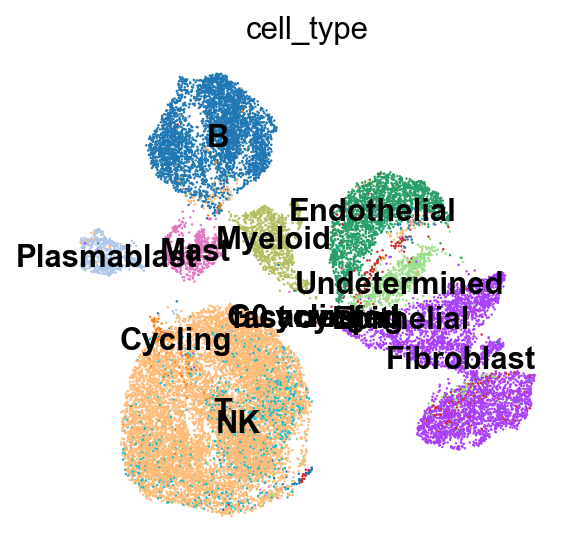

In [12]:
sc.pl.umap(
    post_chemo_adata,
    color=["cell_type"],
    legend_loc="on data",
)

In [13]:
d2c.score(adata, use_raw=True)

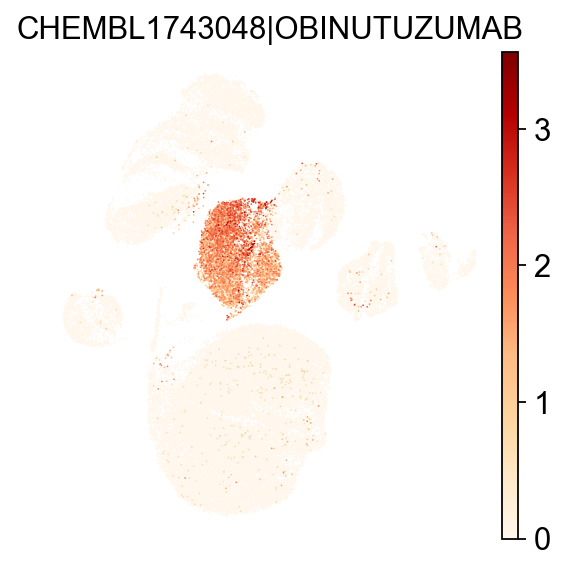

In [14]:
sc.pl.umap(adata.uns['drug2cell'], color="CHEMBL1743048|OBINUTUZUMAB", color_map="OrRd")

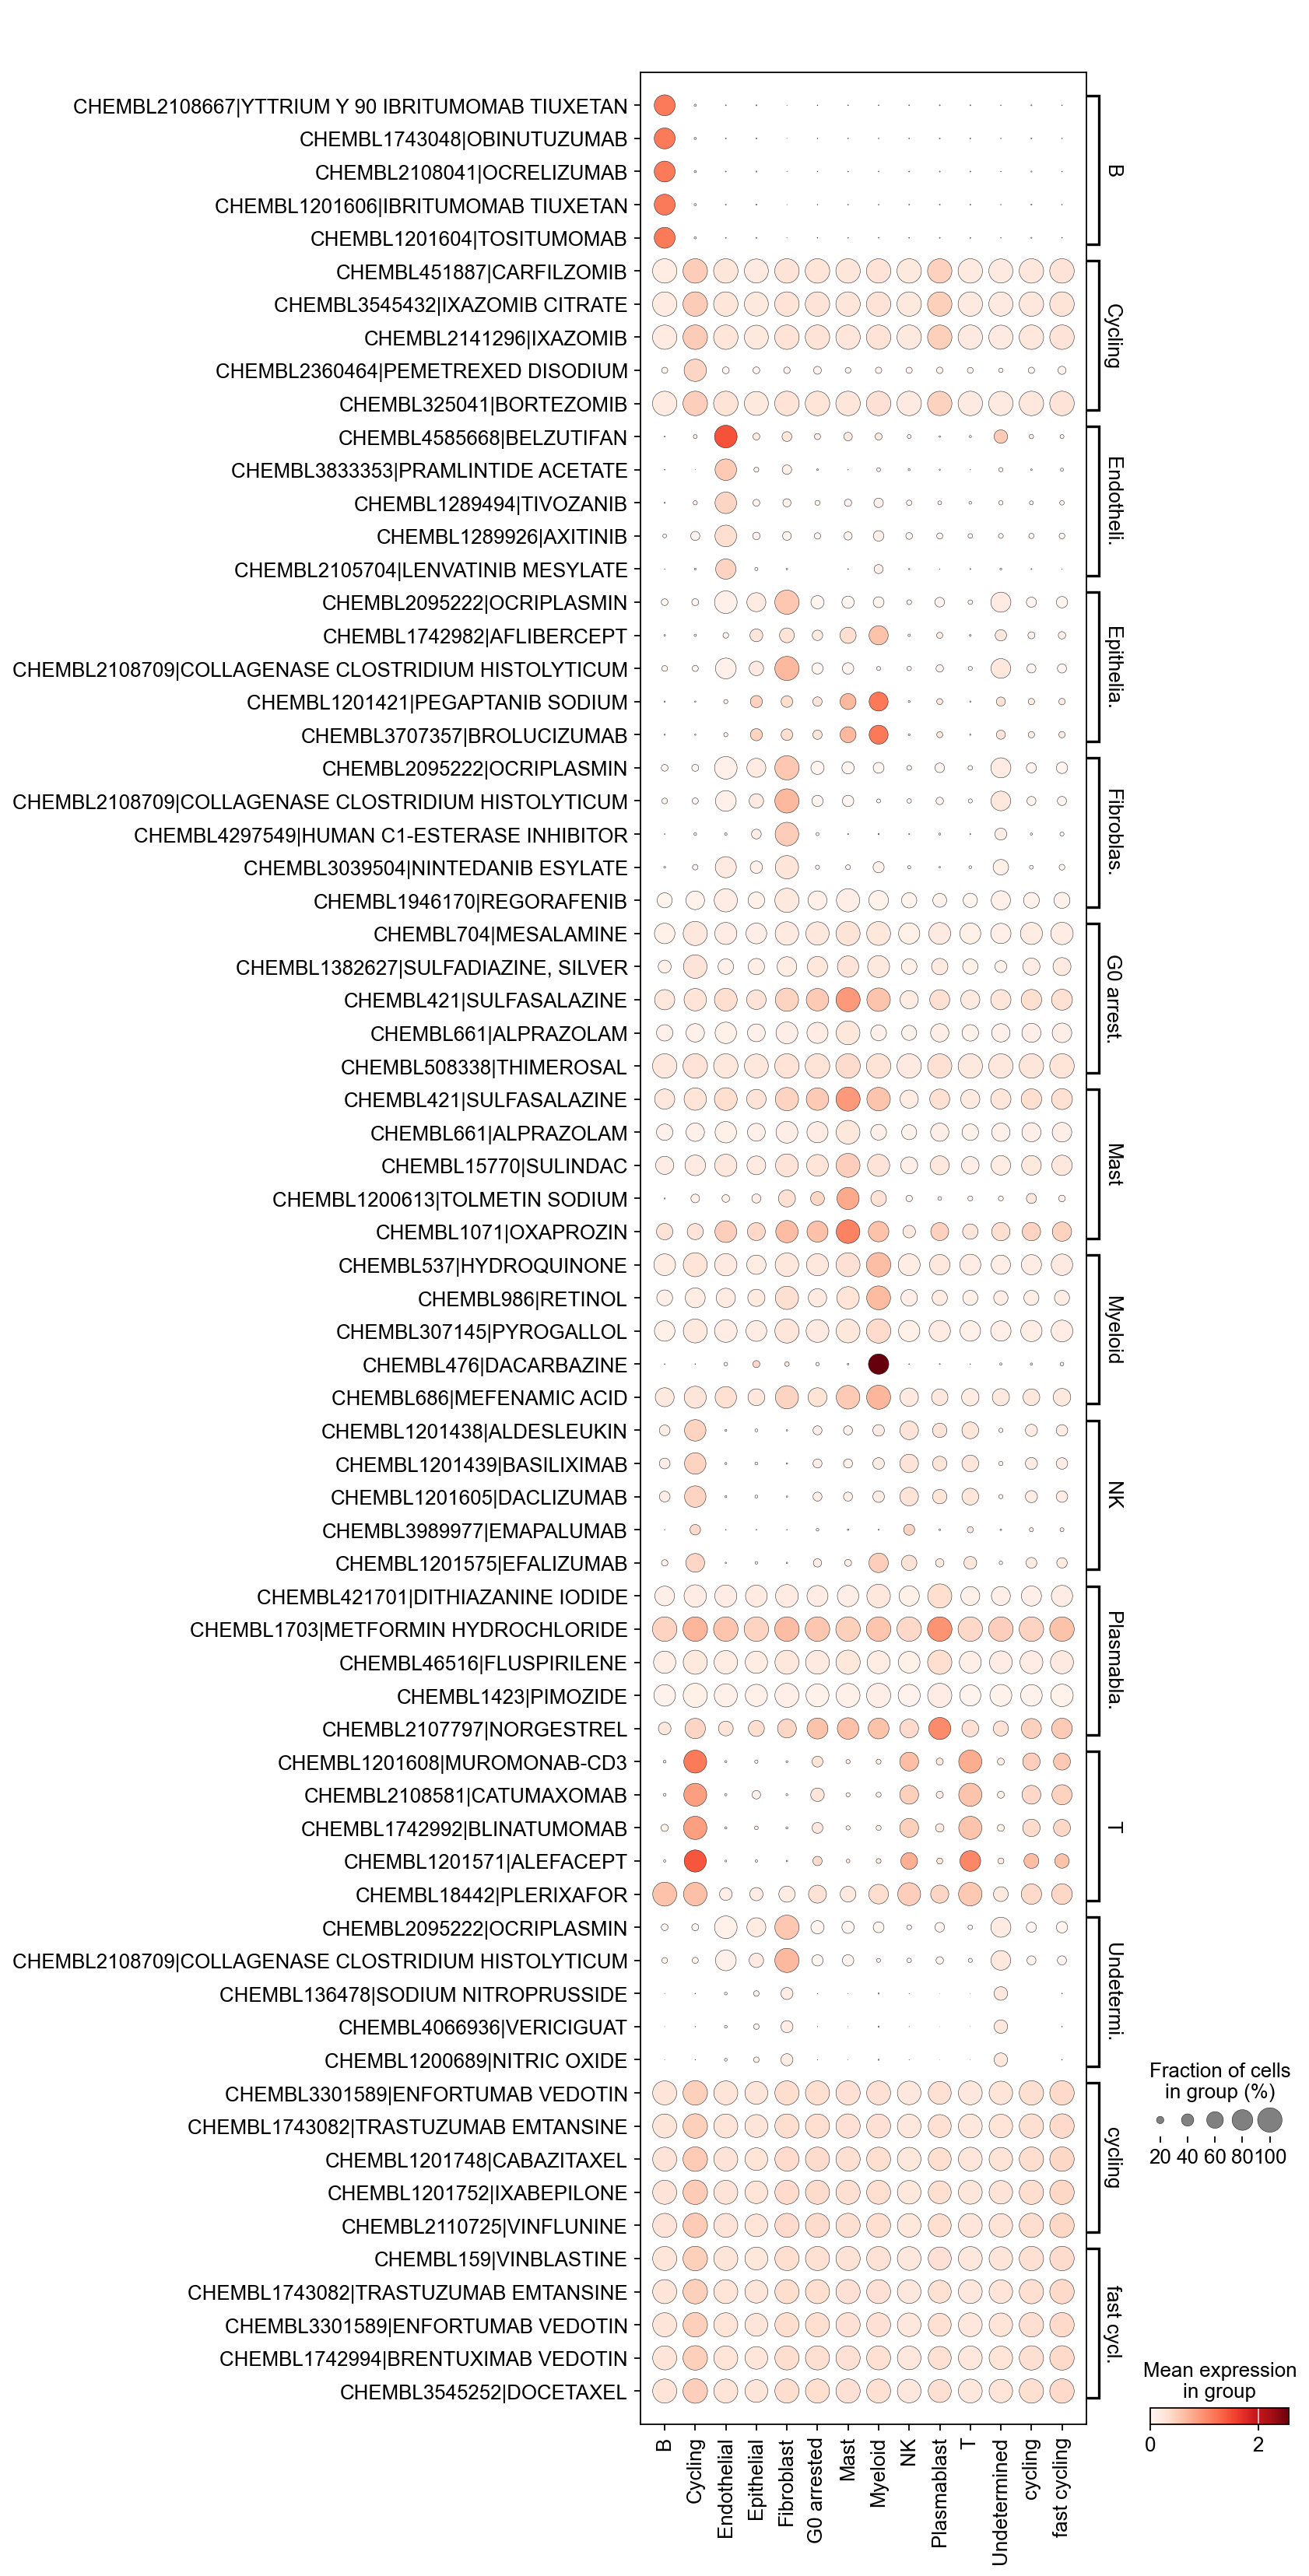

In [15]:
sc.tl.rank_genes_groups(adata.uns['drug2cell'], method="wilcoxon", groupby="cell_type")
sc.pl.rank_genes_groups_dotplot(adata.uns['drug2cell'], swap_axes=True, dendrogram=False, n_genes=5)